## <span style="color:darkblue; font-weight:bold"> GLM 🔍📊📈</span>

igual que el modelo final que obtuve en R, pero normalizando

la deviance sigue siendo 172.3 pero los coeficientes son más "interpretables".

In [31]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the input data
csv = pd.read_csv("../1_datasets/simcomms/processed_data_simcomms_0.5_full_jun16", index_col="sample")
csv = csv.drop(['transfer', 'reached_fixation_at',
               'filename', 'initial_size', 'final_size',
               'filt_even', 'filt_shannon', 'gini'
# 'raw_even', 'richness', 'distrib'
               ], axis=1)

csv["logdilfactor"] = np.log(csv.dilfactor)
csv = csv.dropna()
csv = csv.replace(to_replace="1.00E+06", value=100000)
csv.distrib = [1 if i=="uniform" else 0 for i in csv.distrib]

# Filter by dilution factor (!!!!)
csv = csv[csv.dilfactor < 0.01]
csv = csv[csv.dilfactor > 0.00025]

# out
prefix = "GLM/"



# Normalize the variables in X
y = csv.success.to_list()
variable_names = ["size", "raw_even", "logdilfactor"]
scaler = MinMaxScaler()
csv_normalized = pd.DataFrame(scaler.fit_transform(csv[variable_names]), columns = variable_names)
csv_normalized["success"] = y


# Fit the GLM with a negative exponential distribution
model = sm.formula.glm(formula = "success ~ size:logdilfactor +  raw_even  + size  + logdilfactor",
                       data=csv_normalized,
                       family=sm.families.Gamma(link=sm.families.links.log()))
result = model.fit()

# Show fitted model
print(result.summary())
coefficients = result.params
print(coefficients)

# Regression formula
regression_formula = "y = "
for i in range(len(variable_names)):
    coefficient = coefficients[i]
    variable_name = variable_names[i]
    regression_formula += f"({coefficient:.4f} * {variable_name}) + "

# Print the regression formula
print(regression_formula[0:-3])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                success   No. Observations:                 1845
Model:                            GLM   Df Residuals:                     1840
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                        0.070005
Method:                          IRLS   Log-Likelihood:                -6600.0
Date:                Thu, 29 Jun 2023   Deviance:                       172.27
Time:                        10:29:26   Pearson chi2:                     129.
No. Iterations:                    16   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2651      0.02

- Really good pseudo R-squ. (CS):            "1"

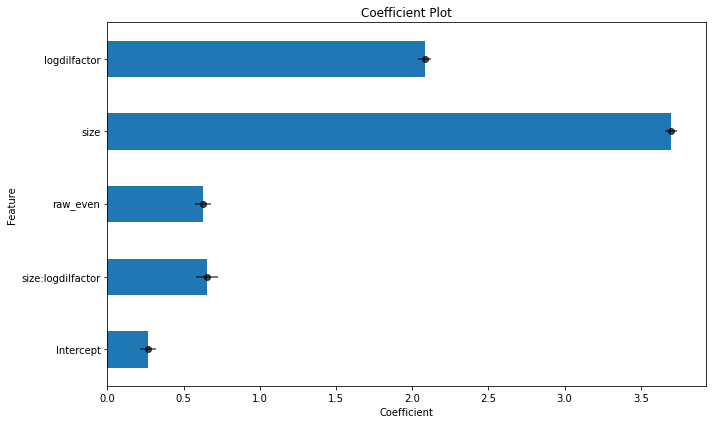

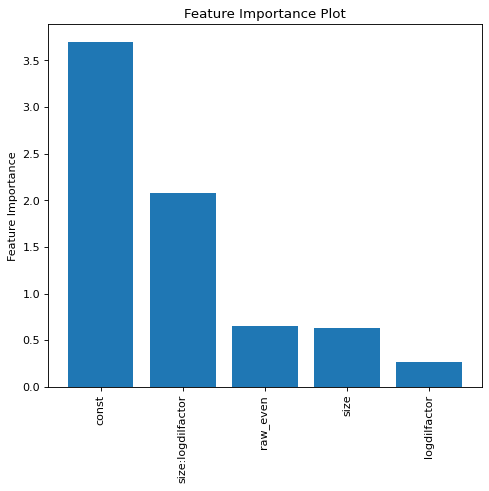

In [45]:
# Coefficient Plot
def plot_coefficients(result):
    coef_df = result.conf_int()
    coef_df['Coefficient'] = result.params
    coef_df.columns = ['Lower CI', 'Upper CI', 'Coefficient']
    coef_df.dropna(inplace=True)

    fig, ax = plt.subplots(figsize=(10, 6))
    coef_df['Coefficient'].plot(kind='barh', ax=ax)
    ax.errorbar(x=coef_df['Coefficient'], y=coef_df.index, xerr=(coef_df['Coefficient'] - coef_df['Lower CI'], coef_df['Upper CI'] - coef_df['Coefficient']),
                fmt='o', color='black', alpha=0.7)
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Feature')
    ax.set_title('Coefficient Plot')

    plt.tight_layout()
    plt.show()

plot_coefficients(result)

# Variable Importance Plot (importance==absolute value of coefficients
def plot_var_importance_plot(result, variable_names):
    importance_df = pd.DataFrame({'Variable': ["const"] + variable_names, # don't include constant
                                  'Importance': list(np.abs(result.params))})
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(7, 6), dpi=80)

    # Create a bar plot of the feature importances
    plt.bar(range(len(variable_names)+1), importance_df.Importance)

    # Add axis labels and a title to the plot
    plt.xticks(range(len(variable_names)+1), ["const"] + variable_names, rotation=90)
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')

    # Add axis labels and a title to the plot
    plt.xticks(range(len(variable_names)+1), ["const"] + variable_names, rotation=90)
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')

    # Show the plot
    plt.savefig(prefix + "feature_importance.png")
    plt.show()
    plt.close()

plot_var_importance_plot(result, list(result.params.index[1:]))

### <span style="color:darkblue; font-weight:bold"> more plots 🔍📊📈</span>


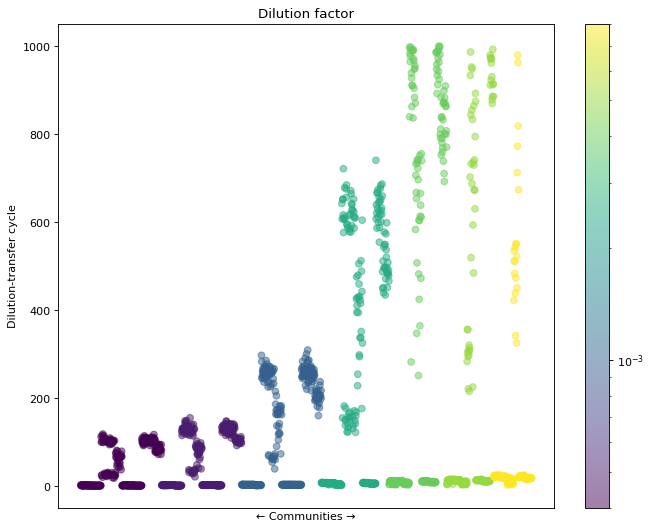

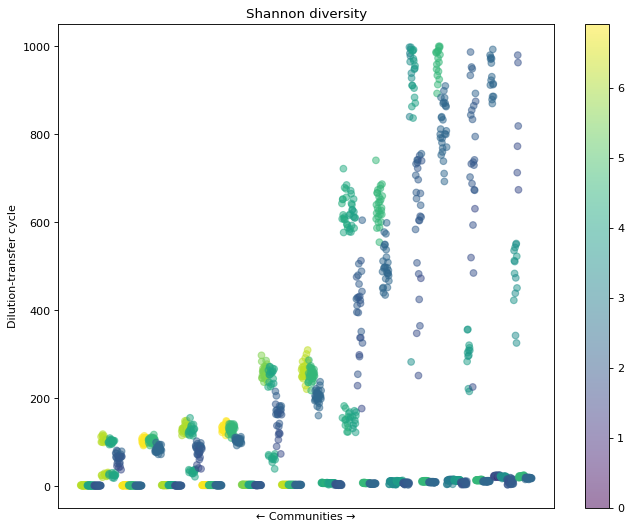

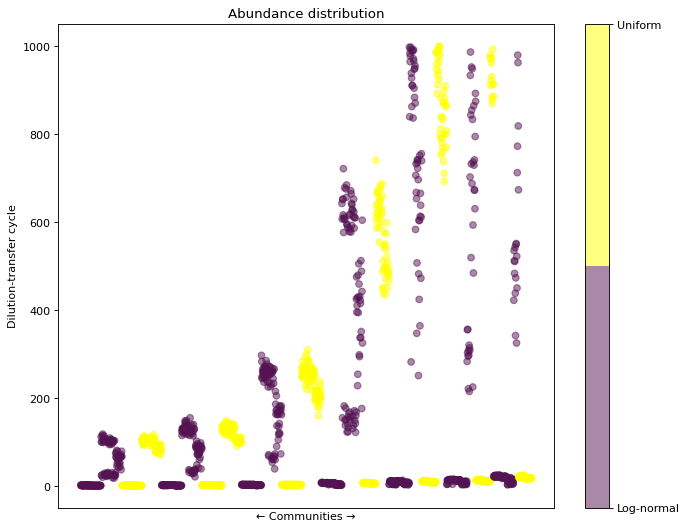

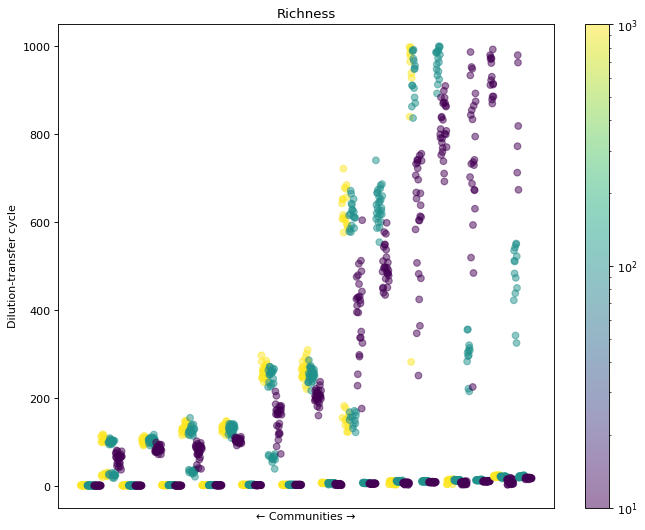

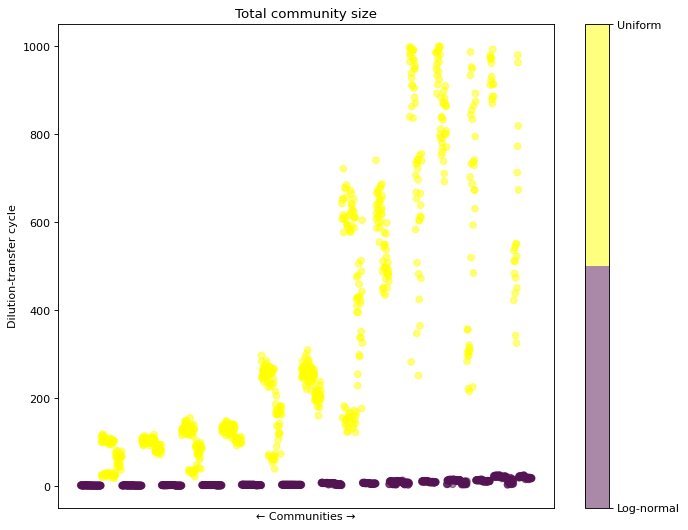

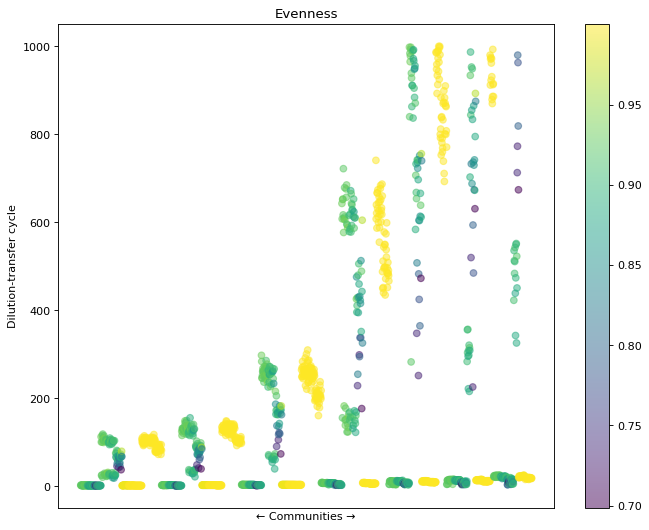

In [48]:
from matplotlib import colors


# Another simple plot is to put all y (real) values in a set order
csv2 = csv#[csv["dilfactor"]==0.04]

for n, i in enumerate(["dilfactor", "raw_shannon", "distrib", "richness", "size", "raw_even"]):
    name = ["Dilution factor", "Shannon diversity", "Abundance distribution", "Richness", "Total community size", "Evenness", "Gini index"][n]
    
    cmap = None
    mynorm = None
    ## Logarithmic color scale for these
    if i in ["richness", "dilfactor"]:
        mynorm = colors.LogNorm()
    ## Not a gradient needed for these
    if i in ["distrib", "size"]:
        cmap = colors.ListedColormap(["#541352FF", "yellow"])  # Binary colormap (viridis)
        bounds = [np.unique(csv2[i]).min(), np.unique(csv2[i]).max()]  # Boundaries for colormap
        
        plt.figure(figsize=(10, 8), dpi=80)
        plt.scatter(range(csv2.shape[0]),
                    csv2.success,
                    c=csv2[i],
                    cmap=cmap,
                    norm=None,
                    facecolors="none",
                    alpha=0.5)
        plt.title(name)
        cbar = plt.colorbar(ticks=bounds)
        cbar.ax.set_yticklabels(["Log-normal", "Uniform"])
    else:
        plt.figure(figsize=(10, 8), dpi=80)
        plt.scatter(range(csv2.shape[0]),
                    csv2.success,
                    c=csv2[i],
                    norm=mynorm,
                    facecolors="none",
                    alpha=0.5)
        plt.title(name)
        plt.colorbar()
    

    plt.title(name)
    plt.ylabel("Dilution-transfer cycle")
    plt.xticks([])
    plt.xlabel("← Communities →")
    plt.savefig(prefix + i + ".png")
    plt.show()
    plt.close()
